In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd

from tensorflow.keras import layers, losses, models, optimizers
from matplotlib import pyplot as plt
from matplotlib import ticker
from collections import deque
from random import sample, shuffle, randrange
from math import floor
from functools import reduce

/Users/broxoli/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DATASET_PARAMS = dict(
    input_shape=(32, 32, 3),
    n_classes=10,
    baseline_accuracy=.1,
)

train_ds, val_ds = tfds.load(
    'cifar10',
    split=['train[:80%]', 'train[20%:]'],
    as_supervised=True
)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-11-08 16:15:05.259631: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-08 16:15:05.260447: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2022-11-08 16:15:05.557707: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-08 16:15:05.585575: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


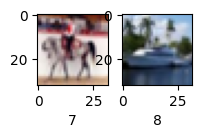

In [4]:
def display(display_list, cols=2, size=(8, 8)):
    rows = (len(display_list) + cols - 1)//cols
    fig, axes = plt.subplots(rows, cols, figsize=size)

    def get_axis(index):
        row, col = index//cols, index%cols
        return axes[row, col] if rows>1 else axes[col]
    
    for index, item in enumerate(display_list):
        image, label = item
        axis = get_axis(index)
        axis.imshow(tf.keras.utils.array_to_img(image))
        axis.set_xlabel(label)

items = []
for item in train_ds.take(2).as_numpy_iterator():
    items.append(item)

display(items, size=(2,2))

In [133]:
CHILD_PARAMS = dict(
    epochs=1,
    batch_size=128,
    learning_rate=0.001,
    train_ds=train_ds,
    val_ds=val_ds,
    max_branch_length=2,
    blocks=5,
    cells=2,
    initial_width=1,
    initial_channels=4
)

STATE_SPACE = [
    dict(name='hidden_state', values=list(range(2)), count=2),
    dict(
        name='primitives',
        values=['sep_3x3', 'sep_5x5', 'sep_7x7', 'avg_3x3', 'max_3x3', 'identity'],
        count=2
    ),
    dict(name='combinations', values=['add', 'concat'], count=1),
]

TDS = CHILD_PARAMS['train_ds'].shuffle(
    500,
    reshuffle_each_iteration=True
).batch(CHILD_PARAMS['batch_size']).take(2)
VDS = CHILD_PARAMS['val_ds'].batch(256).take(2)

class CNNCell():
    """
    It composes a cell based on the input configuration.
    Arguments:
        stride: A positive integer to represent the convolution strides.
            Normal cells use stride=1 and reduction cells use stride=2
    """
    def __init__(self, stride=1, channels=64):
        self.channels = channels
        self.stride = stride
        self.kwargs = dict(strides=(1, 1), padding='same')
    
    def repair_channels(self, inp):
        """
        This method sends the input through a convolution layer with
        a fixed channel size to ensure that the inputs to each cell block
        have identical channel dimensions.
        """
        return layers.Conv2D(self.channels, 1, padding='same')(inp)

    def repair_branches(self, branches):
        """
        It transforms the input branches to an identical feature space.
        It is useful when a cell receives inputs with different feature spaces.
        """
        (hidden_1, width_1), (hidden_2, width_2) = branches

        if width_1 != width_2:
            hidden_1 = layers.Conv2D(
                self.channels,
                3,
                strides=(2,2),
                padding='same'
            )(hidden_1)
        else:
            hidden_1 = self.repair_channels(hidden_1)
        
        hidden_2 = self.repair_channels(hidden_2)
        
        return [hidden_1, hidden_2]
    
    def reduce_inputs(self, inputs):
        """
        It halves the input feature space using a convolution layer with stride 2
        """
        if self.stride == 2:
            inputs = list(
                map(
                    lambda inp: layers.Conv2D(
                        self.channels,
                        3,
                        strides=(2,2),
                        padding='same'
                    )(inp),
                    inputs
                )
            )
        
        return inputs
    
    def apply_op(self, op_id, inp):
        """
        It applies a primitive operation to the input.
        """
        if op_id == 0:
            output = layers.DepthwiseConv2D(3, **self.kwargs)(inp)
        elif op_id == 1:
            output = layers.DepthwiseConv2D(5, **self.kwargs)(inp)
        elif op_id == 2:
            output = layers.DepthwiseConv2D(7, **self.kwargs)(inp)
        elif op_id == 3:
            output = layers.AveragePooling2D(3, **self.kwargs)(inp)
        elif op_id == 4:
            output = layers.MaxPool2D(3, **self.kwargs)(inp)
        elif op_id == 5:
            output = inp
        
        return output

    def combination(self, op_id, inp_1, inp_2):
        """
        It applies a combination operation to the inputs.
        """
        if op_id == 0:
            output = inp_1 + inp_2
        elif op_id == 1:
            x = tf.concat([inp_1, inp_2], -1)
            output = self.repair_channels(x)
        
        return output

    def compose_block(self, block_config, inputs):
        input_1, input_2 = list(map(lambda idx: inputs[idx], block_config[:2]))
        op1, op2 = block_config[2:4]
        combine_op = block_config[-1]

        output = self.combination(
            combine_op,
            self.apply_op(op1, input_1),
            self.apply_op(op2, input_2)
        )

        return output

    def make_cell(self, cell_config, branches):
        """
        It constructs a cell based on the cell_config and the branches.
        A cell_config is 2-D numpy array of shape [5,5] which contains
        the 5 state choices for each of the 5 blocks.
        """
        inputs = self.repair_branches(branches)
        inputs = self.reduce_inputs(inputs)

        blocks = []
        for block in cell_config:
            block_output = self.compose_block(block, inputs)
            blocks.append(block_output)
        
        x = tf.concat(blocks, -1)
        output = self.repair_channels(x)

        return output

class Child(object):
    def __init__(self, config, train=True):
        self.config = config
        self.layers = [(0, 1), (1, 2), (0, 1), (1, 2), (0, 1)]
        self.model = self.make_child()
        self.accuracy = 0.0
        self.accuracy = self.train() if train else 0
        print('Child: {} \n Accuracy: {:1.4f}'.format(
            self.config,
            self.accuracy
        ))
    
    def make_child(self):
        """
        Arguments:
            config: It is an array of shape [2, 5, 5]
                    Each row represents a cell: [Normal, Reduction]
                    Each cell contains 5 blocks.
                    Each block contains 5 operations.

        Returns:
            model: A CNN model with the layers laid out based on the input config.
        """
        inp = tf.keras.Input(shape=DATASET_PARAMS['input_shape'], dtype=tf.uint8)
        x = layers.Rescaling(1./255)(inp)

        width = CHILD_PARAMS['initial_width']
        branches = deque(maxlen=CHILD_PARAMS['max_branch_length'])
        branches.append((x, width))
        branches.append((x, width))

        for cell_type, stride in self.layers:
            width *= stride
            cnn_cell = CNNCell(
                stride,
                channels=CHILD_PARAMS['initial_channels']**width
            )

            x = cnn_cell.make_cell(self.config[cell_type], branches)
            branches.append((x, width))

        x = layers.GlobalAveragePooling2D()(x)
        output = layers.Dense(DATASET_PARAMS['n_classes'], activation='softmax')(x)

        model = tf.keras.Model(inp, output)
        optimizer = optimizers.Adam(learning_rate=CHILD_PARAMS['learning_rate'])

        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics='accuracy'
        )
        # model.summary()

        return model

    def train(self):
        history = self.model.fit(
            TDS,
            validation_data=VDS,
            epochs=CHILD_PARAMS['epochs']
        )
        self.accuracy = max(history.history['val_accuracy'])

        return self.accuracy


CONTROLLER_PARAMS = dict(
    episodes=2,
    population_size=2,
    sample_size=2,
    mutation_size=2
)

BLOCK_TIMESTEPS = 5
CELL_TIMESTEPS = BLOCK_TIMESTEPS*CHILD_PARAMS['blocks']
TOTAL_TIMESTEPS = CELL_TIMESTEPS*CHILD_PARAMS['cells']
STATE_ID_TO_STATE_SPACE_ID = {0:0, 1:0, 2:1, 3:1, 4:2}

TIMESTEP_ADDRESS_SPACE = (
    CHILD_PARAMS['cells'],
    CHILD_PARAMS['blocks'],
    len(STATE_ID_TO_STATE_SPACE_ID)
)
TIMESTEP_ADDRESSES = np.stack(
    np.unravel_index(range(TOTAL_TIMESTEPS),TIMESTEP_ADDRESS_SPACE),
    -1
)

STATE_ADDRESSES = list(map(
    lambda x: [x[0], x[1], STATE_ID_TO_STATE_SPACE_ID[x[2]]],
    TIMESTEP_ADDRESSES
))

class Controller():
    def __init__(self):
        self.population_size = CONTROLLER_PARAMS['population_size']
        self.population = deque(maxlen=self.population_size)
        self.histories = []
        self.sample_size = CONTROLLER_PARAMS['sample_size']
        self.best_accuracies = []
    
    def random_state(self, address):
        (_, __, state_id) = address
        return randrange(len(STATE_SPACE[state_id]['values']))

    def create_random_child(self):
        state = list(map(self.random_state, STATE_ADDRESSES))
        config = np.array(state).reshape(TIMESTEP_ADDRESS_SPACE)
        child = Child(config)
        return child

    def initialize_population(self):
        """
        It creates children as specified through the size parameter.
        Each child is trained and their history is stored.
        It should be called only once.

        Arguments:
            size: The size of the population.
        """
        def work_fn():
            self.population.extend(map(
                lambda _: self.create_random_child(),
                range(self.population_size)
            ))
            self.histories += self.population
        
        work_fn() if not self.population else None
    
    def mutate(self, config):
        state = list(map(self.random_state, STATE_ADDRESSES))
        config = np.array(state).reshape(TIMESTEP_ADDRESS_SPACE)

        def mutate_once():
            mutation_address = tuple(map(randrange, TIMESTEP_ADDRESS_SPACE))
            state_id = mutation_address[-1]
            state_space_id = STATE_ID_TO_STATE_SPACE_ID[state_id]
            mutation = randrange(len(STATE_SPACE[state_space_id]['values']))

            return mutation_address, mutation

        def apply_mutation(config):
            address, mutation = mutate_once()
            print(address, mutation)
            config[address] = mutation
            return config
    
        mutated_config = reduce(
            lambda x,_: apply_mutation(x),
            range(2),
            config.copy())

        return mutated_config
    
    def run_cycle(self):
        # Pick random children from the population for the mutation stage
        p_sample = sample(range(len(self.population)), self.sample_size)

        # Find the best child in the sample
        accuracies = list(map(
            lambda idx: self.population[idx].accuracy,
            p_sample
        ))
        best_sample = np.argmax(accuracies)
        print('Best Child: {:2d} Accuracy: {:4f}'.format(
            p_sample[best_sample],
            accuracies[best_sample]
        ))

        # Record the best accuracies
        self.best_accuracies.append(accuracies[best_sample])

        # Mutate the best child
        best_child = self.population[p_sample[best_sample]]
        mutated_child = Child(self.mutate(best_child.config))

        # Update population
        print('Removal Candidate: {}\n Accuracy: {:1.5f}'.format(
            self.population[0].config,
            self.population[0].accuracy
        ))
        print('Mutation Candidate: {}\n Accuracy: {:1.5f}'.format(
            best_child.config,
            best_child.accuracy
        ))
        self.population.append(mutated_child)
                
        # Add the mutated child to the histories
        self.histories.append(mutated_child)

controller = Controller()
controller.initialize_population()

for episode in range(CONTROLLER_PARAMS['episodes']):
    print('Cycle: ', episode)
    controller.run_cycle()
#     predictions = controller.predict_child(start_state)
    
    # config = np.array(predictions).reshape(TIMESTEP_ADDRESS_SPACE)

    # # Evaluate the child generated by the controller
    # reward, accuracy = child_manager.get_rewards(config)
    # print(
    #     'Episode: {} Reward: {} Accuracy: {}'.format(
    #         episode,
    #         reward,
    #         accuracy
    #     )
    # )

    # # Store predicted child and its rewards
    # controller.save_trial(predictions, reward, accuracy)
    
    # # Train the Controller
    # controller.train_step()

    # # Update start_state for next episode.
    # start_state = np.array([predictions[0]])
    # tf.print('Start State:', start_state)

2022-11-08 12:50:22.755711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 2.3059 - accuracy: 0.0586 

2022-11-08 12:50:33.404316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 19s 5s/step - loss: 2.3059 - accuracy: 0.0586 - val_loss: 2.3131 - val_accuracy: 0.1855


2022-11-08 12:50:36.388449: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-11-08 12:50:36.395040: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Child: [[[0 1 0 2 1]
  [1 1 2 2 0]
  [0 0 3 3 1]
  [1 1 2 2 1]
  [0 0 3 0 0]]

 [[1 1 4 0 1]
  [1 1 1 0 0]
  [1 0 0 4 1]
  [0 0 2 1 1]
  [1 1 2 1 0]]] 
 Accuracy: 0.1855


2022-11-08 12:50:38.380889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 4.0212 - accuracy: 0.0586

2022-11-08 12:50:48.503255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 14s 5s/step - loss: 4.0212 - accuracy: 0.0586 - val_loss: 2.8884 - val_accuracy: 0.1270


2022-11-08 12:50:51.137885: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-11-08 12:50:51.143082: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Child: [[[1 1 5 5 0]
  [1 0 1 2 1]
  [0 1 2 4 1]
  [0 0 4 1 1]
  [0 0 0 3 0]]

 [[1 0 0 4 1]
  [0 1 4 0 1]
  [0 1 3 1 0]
  [0 0 4 2 1]
  [0 0 5 4 1]]] 
 Accuracy: 0.1270
Cycle:  0
Best Child:  0 Accuracy: 0.185547
(1, 3, 0) 1
(0, 4, 2) 5


2022-11-08 12:50:52.979908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 5.0496 - accuracy: 0.0938

2022-11-08 12:51:02.922672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 14s 5s/step - loss: 5.0496 - accuracy: 0.0938 - val_loss: 3.2320 - val_accuracy: 0.1211


2022-11-08 12:51:05.618660: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-11-08 12:51:05.627524: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Child: [[[1 0 3 1 1]
  [0 0 5 1 0]
  [1 1 2 5 1]
  [1 0 0 5 1]
  [1 0 5 3 1]]

 [[0 1 2 4 1]
  [1 1 4 5 1]
  [1 1 5 3 1]
  [1 1 1 5 0]
  [1 1 3 0 1]]] 
 Accuracy: 0.1211
Removal Candidate: [[[0 1 0 2 1]
  [1 1 2 2 0]
  [0 0 3 3 1]
  [1 1 2 2 1]
  [0 0 3 0 0]]

 [[1 1 4 0 1]
  [1 1 1 0 0]
  [1 0 0 4 1]
  [0 0 2 1 1]
  [1 1 2 1 0]]]
 Accuracy: 0.18555
Mutation Candidate: [[[0 1 0 2 1]
  [1 1 2 2 0]
  [0 0 3 3 1]
  [1 1 2 2 1]
  [0 0 3 0 0]]

 [[1 1 4 0 1]
  [1 1 1 0 0]
  [1 0 0 4 1]
  [0 0 2 1 1]
  [1 1 2 1 0]]]
 Accuracy: 0.18555
Cycle:  1
Best Child:  0 Accuracy: 0.126953
(0, 1, 3) 5
(0, 3, 0) 1


2022-11-08 12:51:07.785949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 4.4765 - accuracy: 0.0859

2022-11-08 12:51:17.707331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 14s 5s/step - loss: 4.4765 - accuracy: 0.0859 - val_loss: 2.7725 - val_accuracy: 0.0938
Child: [[[0 1 1 2 1]
  [0 1 0 5 0]
  [0 0 4 5 0]
  [1 0 3 1 1]
  [1 0 4 5 0]]

 [[0 0 0 1 1]
  [0 0 1 5 1]
  [0 0 4 4 0]
  [1 0 2 1 0]
  [1 0 2 5 0]]] 
 Accuracy: 0.0938
Removal Candidate: [[[1 1 5 5 0]
  [1 0 1 2 1]
  [0 1 2 4 1]
  [0 0 4 1 1]
  [0 0 0 3 0]]

 [[1 0 0 4 1]
  [0 1 4 0 1]
  [0 1 3 1 0]
  [0 0 4 2 1]
  [0 0 5 4 1]]]
 Accuracy: 0.12695
Mutation Candidate: [[[1 1 5 5 0]
  [1 0 1 2 1]
  [0 1 2 4 1]
  [0 0 4 1 1]
  [0 0 0 3 0]]

 [[1 0 0 4 1]
  [0 1 4 0 1]
  [0 1 3 1 0]
  [0 0 4 2 1]
  [0 0 5 4 1]]]
 Accuracy: 0.12695


2022-11-08 12:51:20.581215: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-11-08 12:51:20.585990: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


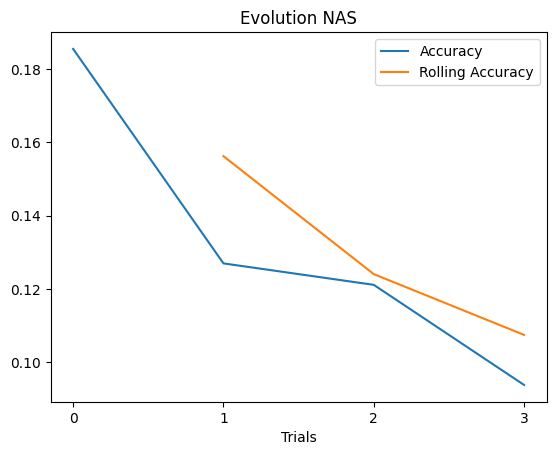

In [134]:
accuracies = list(map(lambda child: child.accuracy, controller.histories))
accuracies_df = pd.DataFrame(accuracies)
rolling_accuracies = accuracies_df.rolling(len(controller.population)).mean()[0].tolist()

plt.plot(accuracies, label='Accuracy')
plt.plot(rolling_accuracies, label='Rolling Accuracy')
plt.xlabel('Trials')
plt.legend()
plt.title('Evolution NAS')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

[0.185546875, 0.126953125]

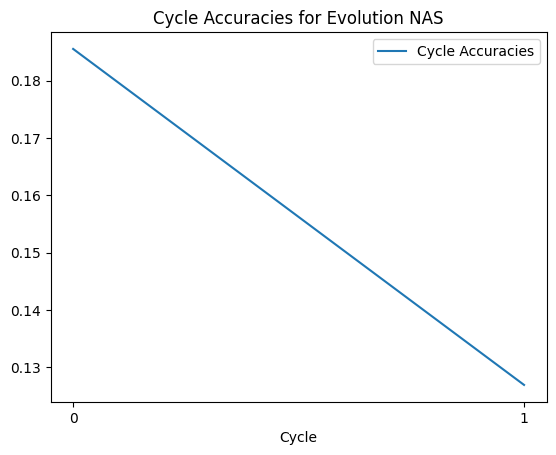

In [135]:
plt.plot(controller.best_accuracies, label='Cycle Accuracies')
plt.xlabel('Cycle')
plt.legend()
plt.title('Cycle Accuracies for Evolution NAS')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

controller.best_accuracies

In [4]:
MEMBER_RUNNING_ID = 0

# Member = namedtuple('Member', ['id', 'gen', 'model'])
class Member(object):
    def __init__(self, member_id, parent, gen, model):
        self.id = member_id
        self.parent = parent
        self.gen = gen
        self.model = model
    
    def __repr__(self):
        return '[id: {}, parent: {}, gen: {}, model: {}]'.format(self.id, self.parent, self.gen, self.model)

def init_model():
    model = tf.keras.Sequential([
        tf.keras.Input((IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        layers.GlobalMaxPooling2D(),
#         tf.keras.Sequential([layers.GlobalMaxPooling2D()]),
        layers.Dense(N_CLASSES, activation='softmax')
    ])
    
    optimizer = optimizers.Adam(learning_rate=0.1)
    loss = 'sparse_categorical_crossentropy'
    metrics = 'accuracy'
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

def init_member(parent=-1, gen=0, model=None):
    global MEMBER_RUNNING_ID
    
    m = Member(MEMBER_RUNNING_ID, parent, gen, model or init_model())
    
    MEMBER_RUNNING_ID += 1
    return m

def let_there_be_light():
    START_POPULATION = 5
    
    return list(map(init_member, range(START_POPULATION)))

POPULATION = let_there_be_light()
POPULATION

[[id: 0, parent: 0, gen: 0, model: <keras.engine.sequential.Sequential object at 0x7f30247060d0>],
 [id: 1, parent: 1, gen: 0, model: <keras.engine.sequential.Sequential object at 0x7f30246ba520>],
 [id: 2, parent: 2, gen: 0, model: <keras.engine.sequential.Sequential object at 0x7f30246824c0>],
 [id: 3, parent: 3, gen: 0, model: <keras.engine.sequential.Sequential object at 0x7f302468cf10>],
 [id: 4, parent: 4, gen: 0, model: <keras.engine.sequential.Sequential object at 0x7f302461ca00>]]

In [5]:
N_ITERATIONS = 3
SURVIVAL_RATE = .7
REPRODUCTION_RATE = .5

def train_member(m):
#     result = m.model.fit(train_ds.batch(2).take(1))
    result = m
    return result

def natural_selection(p):
    def partition(items, size):
        shuffle(items) # In-place shuffle
        left, right = items[:size], items[size:]
        return left, right
    
    mc = len(p) # Member Count
    sc = floor(mc*SURVIVAL_RATE) # Survivals
    survivals, deaths = partition(list(range(mc)), sc) # Survivals and deaths
    
    # Transform survival and death indices to members 
    ids_to_members = lambda ids: list(map(lambda idx: p[idx], ids))
    survivals, _ = ids_to_members(survivals), ids_to_members(deaths)

    return survivals

def reproduction(p):
    def birth(parent):
        # Child Attributes
        parent_id, gen = parent.id, parent.gen+1 
        model = mds.clone_model(parent.model)
    
        child = init_member(parent=parent_id, gen=gen, model=model)
        return child
        
    mc = len(p) # Member Count
    pc = floor(mc*REPRODUCTION_RATE) # Parents
    parents = sample(list(range(mc)), pc)
    
    # Transform parent ids to parents
    parents = map(lambda idx: p[idx], parents)
    
    # Update population with new births
    p.extend(map(birth, parents))
    
    return p

def next_evolution(p):
    def update_member_gen(m):
        m.gen += 1
        return m
    
    # Natural Selection
    p = natural_selection(p)
    
#     # Increment Generation
#     p = list(map(update_member_gen, p))
    
    # Reproduction
    p = reproduction(p)
    
    # Evolve
    result = list(map(train_member, p))
    return result

def calculateDaysBetweenDates()

def run(p):
    result = None
    for step, iteration in enumerate(range(N_ITERATIONS)):
        p = next_evolution(p)
        print(step, p)
        result = p

    return result

run(POPULATION)

0 [[id: 2, parent: 2, gen: 0, model: <keras.engine.sequential.Sequential object at 0x7f30246824c0>], [id: 4, parent: 4, gen: 0, model: <keras.engine.sequential.Sequential object at 0x7f302461ca00>], [id: 1, parent: 1, gen: 0, model: <keras.engine.sequential.Sequential object at 0x7f30246ba520>], [id: 5, parent: 1, gen: 1, model: <keras.engine.sequential.Sequential object at 0x7f302462d3a0>]]
1 [[id: 4, parent: 4, gen: 0, model: <keras.engine.sequential.Sequential object at 0x7f302461ca00>], [id: 5, parent: 1, gen: 1, model: <keras.engine.sequential.Sequential object at 0x7f302462d3a0>], [id: 6, parent: 4, gen: 1, model: <keras.engine.sequential.Sequential object at 0x7f302b93d550>]]
2 [[id: 5, parent: 1, gen: 1, model: <keras.engine.sequential.Sequential object at 0x7f302462d3a0>], [id: 6, parent: 4, gen: 1, model: <keras.engine.sequential.Sequential object at 0x7f302b93d550>], [id: 7, parent: 5, gen: 2, model: <keras.engine.sequential.Sequential object at 0x7f302464f970>]]


[[id: 5, parent: 1, gen: 1, model: <keras.engine.sequential.Sequential object at 0x7f302462d3a0>],
 [id: 6, parent: 4, gen: 1, model: <keras.engine.sequential.Sequential object at 0x7f302b93d550>],
 [id: 7, parent: 5, gen: 2, model: <keras.engine.sequential.Sequential object at 0x7f302464f970>]]